## Importando os módulos necessários

In [11]:
#Importing the modules
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import pickle

import shap

## Subindo e upando os dados

In [12]:
dados = pd.read_csv('Predicao_heat.csv', sep=';')
dados = dados.drop(columns=['Unnamed: 13','Unnamed: 14','Unnamed: 15'])
dados.head()

,L_501,L_503,L_511C,L_511R,L_512,L_521,L_551,L_561,L_562,Trasfega,Filtracao,Brassagem,Heat
0,0.00,0.000,2384.407,0.0,3020.924,0.0,0.000,0.00,0.00,10397,14865.0,17563.8,6.537444e+05
1,0.00,0.000,1621.611,0.0,6076.104,170.8,0.000,2640.00,0.00,12859,3640.0,13985.4,6.439730e+05
2,1407.75,2241.603,2118.966,0.0,2748.683,623.9,202.032,3868.92,441.96,11091,11693.0,12221.7,1.081341e+06
3,2804.25,2814.027,3680.043,0.0,3817.594,35.4,0.000,271.20,1186.14,6238,0.0,14022.1,1.026303e+06
4,3393.75,0.000,4069.322,0.0,6866.077,0.0,0.000,1642.08,797.52,3204,12852.0,12318.0,1.035454e+06


In [13]:
#Calculando a média e o desvio padrão do energia
m=np.mean(dados['Heat'])
d=np.std(dados['Heat'])
a = (m+2*d)
b = m-2*d
c =dados['Heat'].max()
d =dados['Heat'].min()
print(a,b,c,d)

1348658.7471885432 317208.94646432047 2096920.24 0.0


In [14]:
dados.drop(dados[dados.Heat >a].index, inplace=True)
dados.drop(dados[dados.Heat <b].index, inplace=True)
dados_tratados = dados
dados_tratados.count()

L_501        430
L_503        430
L_511C       430
L_511R       430
L_512        430
L_521        430
L_551        430
L_561        430
L_562        430
Trasfega     430
Filtracao    430
Brassagem    430
Heat         430
dtype: int64

In [26]:
X = dados_tratados.drop('Heat', axis=1)
y= dados_tratados['Heat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

regressor = RandomForestRegressor(n_estimators = 900, random_state = 0, max_depth=10)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


(array([ 2.,  1.,  3.,  2.,  6., 16., 14., 20., 27., 17.]),
 array([ 383185.23022241,  448545.26966786,  513905.30911331,
         579265.34855877,  644625.38800422,  709985.42744967,
         775345.46689512,  840705.50634058,  906065.54578603,
         971425.58523148, 1036785.62467694]),
 <BarContainer object of 10 artists>)

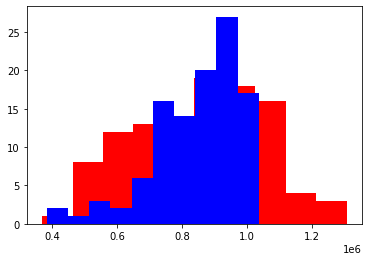

In [27]:

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df
plt.hist(y_test, color ='r')
plt.hist(y_pred, color ='b')

In [28]:
#Métricas do modelo

# Erro absoluto
errors = abs(y_pred - y_test)
error_rf = round(np.mean(errors), 2)
mape = 100 * (errors / y_test)

# Acurácia
accuracy_rf = 100 - np.mean(mape)
accuracy_rf = round(accuracy_rf, 2)

#Erros
MeanSquaredError = metrics.mean_squared_error(y_test,y_pred)
RootMeanSquaredError = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

#Dicionario com a metricas do modelo
Resultados = {
"Erro_Absoluto": error_rf,
"Acuracia_RandomForest": accuracy_rf,
"Erro_Medio_Quadrado": MeanSquaredError,
"RSME": RootMeanSquaredError,
}
print(Resultados)
print(mape.mean())

{'Erro_Absoluto': 141204.93, 'Acuracia_RandomForest': 81.95, 'Erro_Medio_Quadrado': 33794527071.85218, 'RSME': 183832.8781035976}
18.04783468777081


## Plotando a importância das features com SHAP

In [29]:
#Guardando os nomes das features em uma lista
comentarios = list(dados_tratados)
comentarios.remove(comentarios[12])
print(comentarios)

['L_501', 'L_503', 'L_511C', 'L_511R', 'L_512', 'L_521', 'L_551', 'L_561', 'L_562', 'Trasfega', 'Filtracao', 'Brassagem']


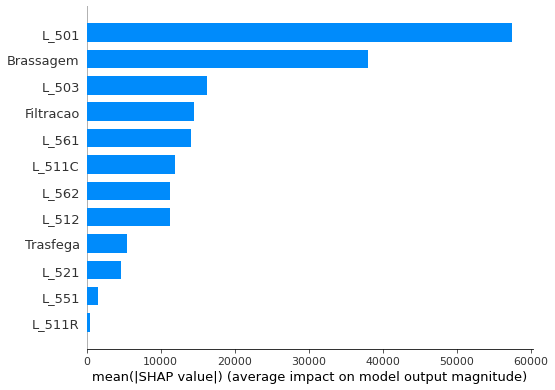

In [30]:
#Plotando a importância das features
shap_values = shap.Explainer(regressor).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar",feature_names=comentarios,show=False)
plt.savefig('barPlot.png')

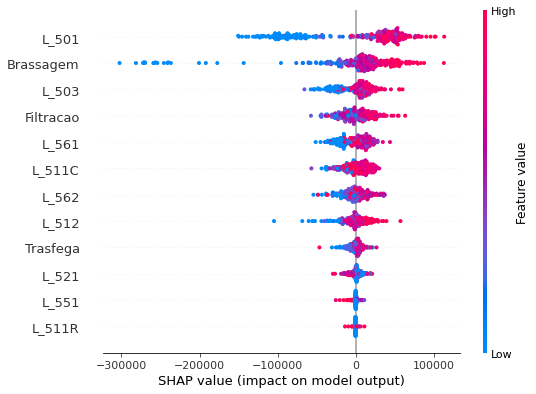

In [31]:
#Plotando como as features impactam o consumo de CO2
f = plt.figure()
shap.summary_plot(shap.TreeExplainer(regressor).shap_values(X_train), X_train,feature_names=comentarios,show=False)
plt.savefig('summaryPlot.png')

 98%|===================| 317/322 [00:43<00:00]        

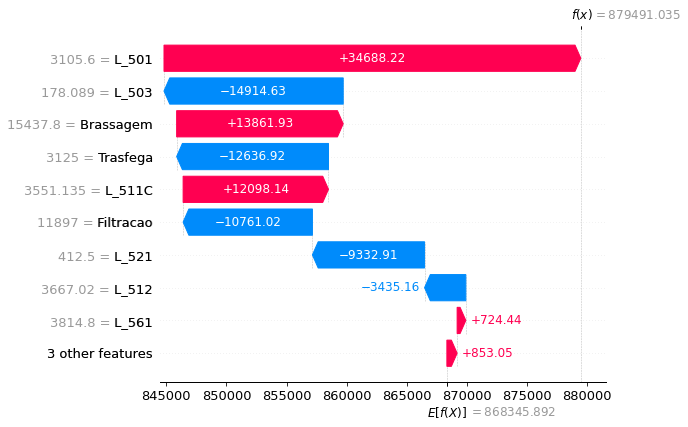

In [32]:
#Plotando o Waterfall para análise
explainer = shap.Explainer(regressor, X_train)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[np.random.randint(0,200)],show=False)
plt.savefig('waterfallPlot.png')

In [33]:
m = np.array([0,0,0,0,0,0,0,0,0,0,0,0])
m = m.reshape(1, -1)
regressor.predict(m)


array([343545.01769322])

In [ ]:
pickle.dump(regressor, open(r'\Users\ITF\Desktop\BS_SCORE_backup\notebooks\Modelo_treinado_BS2.pkl','wb'))